In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

## Classes and functions

In [2]:
from scipy.signal import argrelextrema, find_peaks

def get_spike_times(ts, V):
    spike_idx = find_peaks(V, height=(25., 42.), distance=14.)[0]
    return ts[spike_idx]

def get_idx(t):
    return np.around(t / step_size).astype(np.int32)

### S12 transformation
$$I_{syn}(t) = - \frac{g_{max}}{N} \sum_{\tau_l} \sum_{spikes} \alpha(t - t_{spike} - \tau_l) (V(t) - E_{syn})$$
$$I_{syn}(t) = - \frac{g_{max}}{N} \sum_{\tau_l} \sum_{spikes} (\alpha(t) - \alpha(t_{spike}) - \alpha(\tau_l)) (V(t) - E_{syn})$$
$$I_{syn}(t) = - \frac{g_{max}}{N} (V(t) - E_{syn}) \sum_{\tau_l} \left(\sum_{spikes} \alpha(t) - \alpha(t_{spike})\right) - \alpha(\tau_l) $$

In [3]:
class hh_neuron:
    
    def __init__(self, my_id, config={}):
        self.C = 1.
        self.g_Na = 120.
        self.g_K = 36.
        self.g_L = .3
        self.E_Na = 50.
        self.E_K = -77.
        self.E_L = -54.5
        self.I_ext = 10.
        self.tau_d = 3.
        self.tau_r = .1
        self.sim_n = 1
        self.id = my_id
        
        if 'C' in config.keys():
            self.C = config['C']
        if 'g_Na' in config.keys():
            self.g_Na = config['g_Na']
        if 'g_K' in config.keys():
            self.g_K = config['g_K']
        if 'g_L' in config.keys():
            self.g_L = config['g_L']
        if 'E_Na' in config.keys():
            self.E_Na = config['E_Na']
        if 'E_K' in config.keys():
            self.E_K = config['E_K']
        if 'E_L' in config.keys():
            self.E_L = config['E_L']
        if 'I_ext' in config.keys():
            self.I_ext = config['I_ext']
        if 'tau_d' in config.keys():
            self.tau_d = config['tau_d']
        if 'tau_r' in config.keys():
            self.tau_r = config['tau_r']
        
        self.inc = []
        self.outc = []
        self.V = None
        self.m = None
        self.h = None
        self.n = None

    def alpha_m(self, V):
        """S5"""
        return .1 * (V + 40.) / (1. - np.exp(-(V + 40.) / 10.))

    def beta_m(self, V):
        """S6"""
        return 4. * np.exp(-(V + 65.) / 18.)

    def alpha_h(self, V):
        """S7"""
        return .07 * np.exp(-(V + 65.) / 20.)

    def beta_h(self, V):
        """S8"""
        return 1. / (1. + np.exp(-(V + 35.) / 10.))

    def alpha_n(self, V):
        """S9
        "/ 10" appears to be a typo in the paper.
        Other resources say "/ 100" """
        return ((V + 55.) / 100.) / (1. - np.exp((-.1) * (V + 55.)))

    def beta_n(self, V):
        """S10"""
        return .125 * np.exp(-(V + 65.) / 80.)

    def dm(self, V, m):
        """S2"""
        a = self.alpha_m(V)
        b = self.beta_m(V)

        return a * (1. - m) - b * m

    def dh(self, V, h):
        """S3"""
        a = self.alpha_h(V)
        b = self.beta_h(V)

        return a * (1. - h) - b * h

    def dn(self, V, n):
        """S4"""
        a = self.alpha_n(V)
        b = self.beta_n(V)

        return a * (1. - n) - b * n

    def dV(self, t, V, m, h, n):
        """S1"""
        I_syn = self.I_syn(t)
        
        return (- self.g_Na * m ** 3 * h * (V - self.E_Na) 
                - self.g_K * n ** 4 * (V - self.E_K) 
                - self.g_L * (V - self.E_L) 
                + self.I_ext + I_syn ) / self.C
    
    def setup(self, size, m0, h0, n0, V0):
        self.m = np.zeros((size))
        self.h = np.zeros((size))
        self.n = np.zeros((size))
        self.V = np.zeros((size))
        
        self.m[0] = m0
        self.h[0] = h0
        self.n[0] = n0
        self.V[0] = V0
    
    def register_in(self, connection):
        self.inc.append(connection)
        
    def register_out(self, connection):
        self.outc.append(connection)
    
    def alpha(self, t):
        """S11"""
        return (np.exp(-t / tau_d) - np.exp(-t / tau_r)) / (tau_d - tau_r)
    
    def I_syn(self, t): 
        """S12"""
        idx = get_idx(t)
        I_syn = 0.
        
        for c in self.inc:
            
            t_spike_grid, tau_l_grid = np.meshgrid(get_spike_times(ts[:idx], self.V[:idx]), c.tau_ls)
            alphas = self.alpha(t - t_spike_grid - tau_l_grid)
            
            # S12 summed up over all incomming connections
            I_syn -= g_max / N * np.sum(alphas) * (self.V[idx] - c.E_syn)
    
        return I_syn
    
    def get_input_delays(self):
        d = self.inc[0].tau_ls
        for c in self.inc[1:]:
            np.concatenate((d, c.tau_ls))
        return d
                                    
    def get_input_potentials(self):
        p = []
        for c in self.inc:
            p.append(np.full((int(N)), c.E_syn))
        return np.array(p)
                                    
    def heun_step(self, t):
        i = get_idx(t)
                                   
        # intermediate
        m_i = self.m[i-1] + step_size * self.dm(self.V[i-1], self.m[i-1])
        h_i = self.h[i-1] + step_size * self.dh(self.V[i-1], self.h[i-1])
        n_i = self.n[i-1] + step_size * self.dn(self.V[i-1], self.n[i-1])
        V_i = self.V[i-1] + step_size * self.dV(t-step_size, self.V[i-1], self.m[i-1], self.h[i-1], self.n[i-1])
                                   
        # final
        self.m[i] = self.m[i-1] + (step_size / 2.) * (self.dm(self.V[i-1], self.m[i-1]) + self.dm(V_i, m_i))
        self.h[i] = self.h[i-1] + (step_size / 2.) * (self.dh(self.V[i-1], self.h[i-1]) + self.dh(V_i, h_i))
        self.n[i] = self.n[i-1] + (step_size / 2.) * (self.dn(self.V[i-1], self.n[i-1]) + self.dn(V_i, n_i))
        self.V[i] = self.V[i-1] + (step_size / 2.) * (self.dV(t-step_size, self.V[i-1], self.m[i-1], self.h[i-1], self.n[i-1]) + self.dV(t, V_i, m_i, h_i, n_i))
     
    def get_phase(self, t):
        """
        returns the angle of the polar coordinates 
        of n(t) (~y) and V(t) (~x)
        """
        
        i = get_idx(t)
        
        # translate to origin according to the 
        # precalculated phase cycle
        V_transl = (self.V[i] - V_phase_mean) / (V_phase_max - V_phase_min)
        n_transl = (self.n[i] - n_phase_mean) / (n_phase_max - n_phase_min)
        
        # alpha = arctan(y / x), alpha in [-pi, +pi]
        # shift by pi to get alpha within [0, 2pi]
        return np.arctan(n_transl / V_transl) + np.pi

In [4]:
class Connection():
    
    def __init__(self, neuron_a, neuron_b, tau_ls, E_syn):
        self.neuron_a = neuron_a
        self.neuron_b = neuron_b
        self.neuron_a.register_out(self)
        self.neuron_b.register_in(self)
        self.tau_ls = np.array(tau_ls)
        self.E_syn = E_syn

## Configuration

In [5]:
np.random.seed(42)

hh_config = {
    'C': 1.,
    'g_Na': 120.,
    'g_K': 36.,
    'g_L': .3,
    'E_Na': 50.,
    'E_K': -77.,
    'E_L': -54.5,
    'I_ext': 10.
}

tau_d = 3.
tau_r = .1
g_max = .05
N = 15.
tau_ls = np.full((int(N)), .8)
E_syn = 0.

step_size = .02
t0 = 0.
m0 = 0.05
h0 = 0.6
n0 = 0.32
V0 = -30.

t_end = 3000.

ts = np.arange(t0, t_end, step_size)

hh_alpha = hh_neuron(0, hh_config)
hh_beta = hh_neuron(1, hh_config)
hh_gamma = hh_neuron(2, hh_config)
neurons = [hh_alpha, hh_beta, hh_gamma]

## Simulation

In [6]:
def simulate(ts):
    for t in ts[1:]:
        for neuron in neurons:
            neuron.heun_step(t)

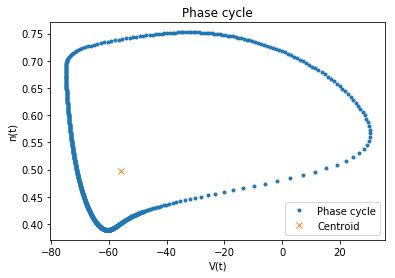

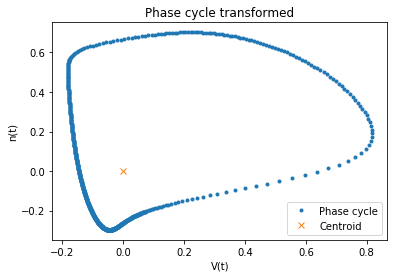

In [7]:
# warmup
ts_wu = np.arange(0, 14.7 * 3., step_size)
for neuron in neurons:
    neuron.setup(ts_wu.size, m0, h0, n0, V0)
simulate(ts_wu)


# save one phase of n and V

# warmup is 3 phases long, so cut the last third 
# to securely get data, which is already following the phase dynamics
start_idx = int(14.5 * 2 / step_size)
V_phase = neurons[0].V[start_idx:]
n_phase = neurons[0].n[start_idx:]

# calculate the centroid of the phase cycle
V_phase_mean = np.mean(V_phase)
n_phase_mean = np.mean(n_phase)
V_phase_min = np.min(V_phase)
n_phase_min = np.min(n_phase)
V_phase_max = np.max(V_phase)
n_phase_max = np.max(n_phase)

# plot cycle without transformation
plt.plot(V_phase, n_phase, ".")
plt.plot(V_phase_mean, n_phase_mean, "x")
plt.legend(["Phase cycle", "Centroid"])
plt.ylabel("n(t)")
plt.xlabel("V(t)")
plt.title("Phase cycle")
plt.show()

# translate the phase cycle to the origin
V_phase -= V_phase_mean
n_phase -= n_phase_mean

# scale cycle for phase determination
V_phase /= V_phase_max - V_phase_min
n_phase /= n_phase_max - n_phase_min

# plot cycle with transformation
plt.plot(V_phase, n_phase, ".")
plt.plot(np.mean(V_phase), np.mean(n_phase), "x")
plt.legend(["Phase cycle", "Centroid"])
plt.ylabel("n(t)")
plt.xlabel("V(t)")
plt.title("Phase cycle transformed")
plt.show()

In [8]:
# cut first phase
phase_len = int(14.7 / step_size)
for neuron in neurons:    
    neuron.m = neuron.m[phase_len:]
    neuron.h = neuron.h[phase_len:]
    neuron.n = neuron.n[phase_len:]
    neuron.V = neuron.V[phase_len:]

# shift phases randomly and reset neurons with new random states
for neuron in neurons:
    shift = int(np.random.rand() * 14.7 / step_size)
    
    m0 = np.roll(neuron.m, shift)[0]
    h0 = np.roll(neuron.h, shift)[0]
    n0 = np.roll(neuron.n, shift)[0]
    V0 = np.roll(neuron.V, shift)[0]
    
    neuron.setup(ts.size, m0, h0, n0, V0)
    
# connect neurons
connections = []
connections.append(Connection(hh_alpha, hh_gamma, tau_ls, E_syn))
connections.append(Connection(hh_gamma, hh_alpha, tau_ls, E_syn))
connections.append(Connection(hh_beta, hh_gamma, tau_ls, E_syn))
connections.append(Connection(hh_gamma, hh_alpha, tau_ls, E_syn))
    
# simulate
simulate(ts)

## Evaluation

In [9]:
def p(t, m, n):
    """S16"""
    i = np.sqrt(-1 + 0j)
    return .5 * np.abs(np.exp(i * m.get_phase(t)) + np.exp(i * n.get_phase(t)))

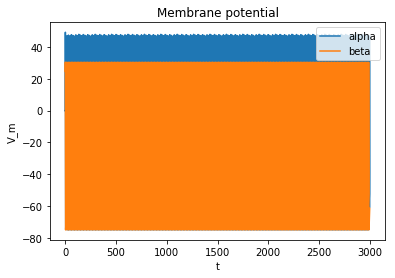

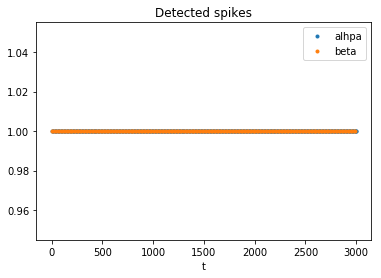

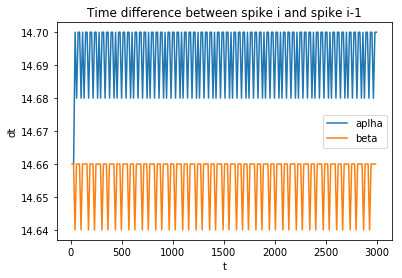

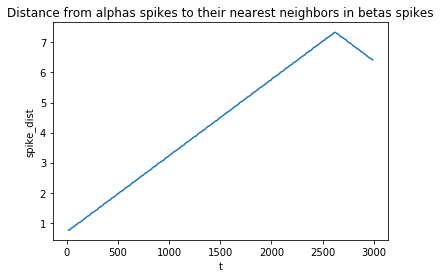

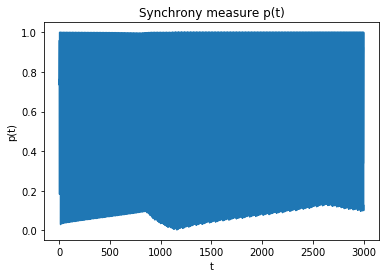

In [10]:
# only plot alpha and beta to visualize synchrony
for neuron in neurons[:-1]:
    plt.plot(ts, neuron.V)
plt.legend(["alpha", "beta", "gamma"])
plt.title("Membrane potential")
plt.ylabel("V_m")
plt.xlabel("t")
plt.show()

# plot spikes
for neuron in neurons[:-1]:
    spike_idx = argrelextrema(neuron.V, np.greater)[0]
    y_val = np.full(len(spike_idx), 1)
    plt.plot(ts[spike_idx], y_val, ".")
plt.legend(["alhpa", "beta", "gamma"])
plt.title("Detected spikes")
plt.xlabel("t")
plt.show()

# phase lengths
sta = get_spike_times(ts, neurons[0].V)
pla = []
for i in range(1, sta.shape[0]):
    pla.append(sta[i] - sta[i-1])

stb = get_spike_times(ts, neurons[1].V)
plb = []
for i in range(1, stb.shape[0]):
    plb.append(stb[i] - stb[i-1])

plt.plot(sta[1:], pla)
plt.plot(stb[1:], plb)
plt.legend(["aplha", "beta"])
plt.title("Time difference between spike i and spike i-1")
plt.xlabel("t")
plt.ylabel("dt")
plt.show()

# nearest spike neighbor
from scipy.spatial import KDTree
sta = np.reshape(sta, (sta.shape[0], 1))
stb = np.reshape(stb, (stb.shape[0], 1))
alpha_tree = KDTree(sta)
nn_dist, nn_idx = alpha_tree.query(stb, 1)
plt.plot(stb[1:], nn_dist[1:])
plt.title("Distance from alphas spikes to their nearest neighbors in betas spikes")
plt.ylabel("spike_dist")
plt.xlabel("t")
plt.show()

# synchrony measure
ps = []
ps = p(ts, neurons[0], neurons[1])
plt.plot(ts, ps)
plt.title("Synchrony measure p(t)")
plt.ylabel("p(t)")
plt.xlabel("t")
plt.show()